In [1]:
import numpy as np
import math
import time
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import chi2
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import ksone #for Kolmogorov-Smirnov test
from scipy.stats import kstest #for checking Kolmogorov-Smirnov test
from scipy.stats import ks_2samp #for checking Kolmogorov-Smirnov 2sample test
from scipy.stats import chisquare #for checking Chi-square test

In [2]:
def gen_expon_values(n, lambd):
    vals = np.random.exponential(scale=1.0/lambd, size=n)
#     vals = expon.rvs(scale = 1.0/lambd, size = n)
    return vals

def make_hist(X, Xname, n, Y, Yname, m):
    figure, axis = plt.subplots(1, 2, figsize=(8,2.5))
    axis[0].hist(X, 30, density = True)
    axis[0].set_title(f"{Xname}: {n} спостережень")
    axis[1].hist(Y, 30, density = True)
    axis[1].set_title(f"{Yname}: {m} спостережень")
    plt.show()
    
def F_expon(u, lambd):
    return 1 - np.exp(- lambd * u)

def F_unif(u):
    if u>=1:
        return 1
    elif u<0:
        return 0
    else:
        return u
#     return uniform.cdf(u, loc=0, scale=1)

In [3]:
gamma = 0.05 #рівень значимості
Z_gamma = 1.36

n = [1000, 10000, 100000]

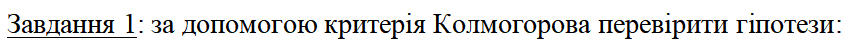
https://www.geeksforgeeks.org/ml-kolmogorov-smirnov-test/<br>
https://mipt-stats.gitlab.io/files/applied_stats_19/lectures/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B8%20%D1%81%D0%BE%D0%B3%D0%BB%D0%B0%D1%81%D0%B8%D1%8F%20%D0%B2%20scipy.pdf

In [4]:
def checker_expon(X, lambd_teor, gamma):
    x = kstest(X, expon(scale=1.0/lambd_teor).cdf)
    if x.pvalue < gamma:
        return 'rejected'
    else:
        return 'accepted'

In [5]:
def Dn(X, n, param):
    X_ord = np.sort(X) #order statistics
    maximum = float('-inf')
    for k in range(n):
        F_k = F_expon(X_ord[k], param)
        a = F_k - (k-1)/n
        b = k/n - F_k
        m = max(a,b)
        if m > maximum:
            maximum = m    
    return maximum


def kolmogorov_test(X, n, param, gamma):
    res = None
#     Z_gamma = ksone.ppf(1-gamma/2, n)
    print("Z_gamma =", Z_gamma)
    D = Dn(X, n, param)
#     print("D=", D)
    if math.sqrt(n) * D < Z_gamma:
        print("Ho ACCEPTED")
        res = 'accepted'
    else:
        print("Ho REJECTED")
        res = 'rejected'
    c = checker_expon(X, lambd_teor, gamma)
    print(f"validation: {c == res}")
    return res

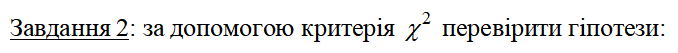

In [31]:
def get_equal_intervals(r, h):
    ai = [0]
    s = 0
    for j in range(r):
        ai.append(s+h)
        s = s+h
    return ai

def get_v(X, xmax, r, h):
    v = [0 for i in range(r)]
    for x_i in X:
        if x_i == xmax:
            v[-1]+=1
        else:
            ind = int(x_i/h)
            v[ind]+=1
    return v

def get_p(r, lambd, breakpoints):
    funcs = [F_expon(point, lambd) for point in breakpoints]
    p = [(funcs[i] - funcs[i-1]) for i in range(1, r+1)]  
    return p

def get_delta(n, r, v, p):
    s = 0
    for i in range(r):
        s += (v[i] - n*p[i])**2 /p[i]
    res = s/n 
    return res

def chi2_pearson_test(X, n, gamma, lambd_teor):
    r = int(0.03 * n) # кількість інтервалів
    res = None
    Z_gamma = chi2.ppf(1-gamma, df = r-1)
    print("Z_gamma=", Z_gamma)
    xmax = np.max(X)
    h = xmax / r # ширина інтервалу
#     print("r=", r, "h=", h)
    breakpoints = get_equal_intervals(r, h)
    v = get_v(X, xmax, r, h) #вектор частот
    p = get_p(r, lambd_teor, breakpoints)
    delta = get_delta(n, r, v, p)
    print('delta=', delta)
    if delta < Z_gamma:
        print("Ho ACCEPTED")
        res = 'accepted'
    else:
        print("Ho REJECTED")
        res = 'rejected'
    return res

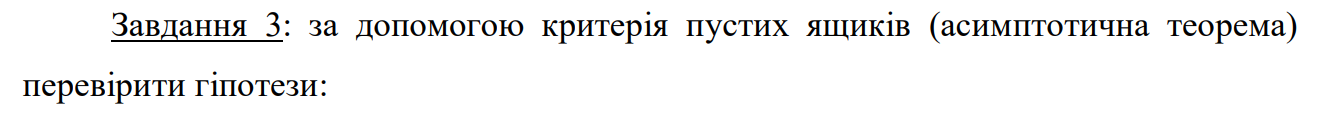

In [29]:
def empty_box_test(X, n, lambda_teor, gamma):
    Z_gamma = norm.ppf(1-gamma, loc=0, scale=1) 
    r = int(n/2)
    ro = 2
    Y = [F_expon(x_i, lambda_teor) for x_i in X]
    ymax = np.max(Y)
    h = ymax/r
    breakpoints = get_equal_intervals(r, h)
    v = get_v(Y, ymax, r, h) #вектор частот
    k = np.sum( np.array(v) == 0)
    e_ro = np.exp(-ro)
    bound = r * e_ro + Z_gamma * np.sqrt(r * e_ro * (1-(1+ro)*e_ro))
    print("k=", k)
    print("bound=", bound)
    if k < bound:
        print("Ho ACCEPTED")
    else:
        print("Ho REJECTED")
        
def check_Y_box(Y, n, gamma):
    print("\nChecking Y")
    Z_gamma = norm.ppf(1-gamma, loc=0, scale=1) 
    r = int(n/2)
    ro = 2
    B = [F_unif(y_i) for y_i in Y]
    bmax = np.max(B)
    h = bmax/r
    breakpoints = get_equal_intervals(r, h)
    v = get_v(B, bmax, r, h) #вектор частот
    k = np.sum( np.array(v) == 0)
    e_ro = np.exp(-ro)
    bound = r * e_ro + Z_gamma * np.sqrt(r * e_ro * (1-(1+ro)*e_ro))
    if k < bound:
        print("Y IS uniform")
    else:
        print("Y NOT uniform")

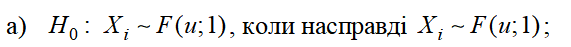

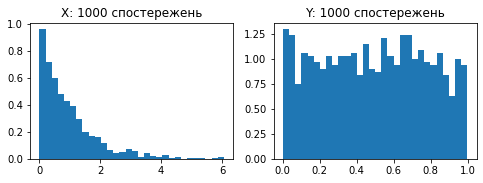

n= 1000
----Критерій Колмогорова----
Z_gamma = 1.36
Ho ACCEPTED
validation: True

Checking Y
Y IS uniform

----Критерій хі-квадрат----
Z_gamma= 42.55696780429269
delta= 26.728691526480144
Ho ACCEPTED

Checking Y
Y IS uniform

----Критерій пустих ящиків----
k= 64
bound= 78.09582983486621
Ho ACCEPTED

Checking Y
Y IS uniform
-----------------------------------------


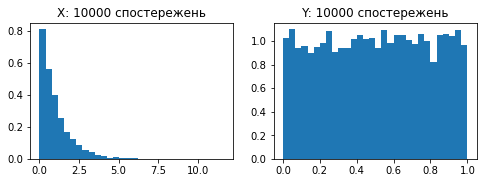

n= 10000
----Критерій Колмогорова----
Z_gamma = 1.36
Ho ACCEPTED
validation: True

Checking Y
Y IS uniform

----Критерій хі-квадрат----
Z_gamma= 340.3278503488595
delta= 569.1863064643148
Ho REJECTED

Checking Y
Y IS uniform

----Критерій пустих ящиків----
k= 684
bound= 709.653242816322
Ho ACCEPTED

Checking Y
Y IS uniform
-----------------------------------------


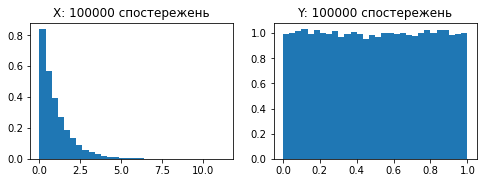

n= 100000
----Критерій Колмогорова----
Z_gamma = 1.36
Ho ACCEPTED
validation: True

Checking Y
Y IS uniform

----Критерій хі-квадрат----
Z_gamma= 3127.515431571307
delta= 3209.9240113136025
Ho REJECTED

Checking Y
Y IS uniform

----Критерій пустих ящиків----
k= 6691
bound= 6871.0460439962335
Ho ACCEPTED

Checking Y
Y IS uniform
-----------------------------------------


In [32]:
lambd_real = 1 #яка насправді
lambd_teor = 1 #яку ми перевіряємо

for n_i in n:
    X = gen_expon_values(n_i, lambd_real)
    Y = F_expon(X, lambd_teor)
    make_hist(X, 'X', n_i, Y, 'Y', n_i)
    print("n=", n_i)
    print("----Критерій Колмогорова----")
    kolmogorov_test(X, n_i, lambd_teor, gamma)
    check_Y_box(Y, n_i, gamma)
    
    print("\n----Критерій хі-квадрат----")
    chi2_pearson_test(X, n_i, gamma, lambd_teor)
    check_Y_box(Y, n_i, gamma)
    
    print("\n----Критерій пустих ящиків----")
    empty_box_test(X, n_i, lambd_teor, gamma)
    check_Y_box(Y, n_i, gamma)
    
    print("-----------------------------------------")

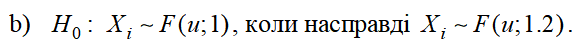

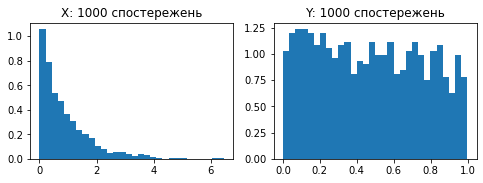

n= 1000
----Критерій Колмогорова----
Z_gamma = 1.36
Ho REJECTED
validation: True

Checking Y
Y IS uniform

----Критерій хі-квадрат----
Z_gamma= 42.55696780429269
delta= 26.773570179350408
Ho ACCEPTED

Checking Y
Y IS uniform

----Критерій пустих ящиків----
k= 72
bound= 78.09582983486621
Ho ACCEPTED

Checking Y
Y IS uniform
-----------------------------------------


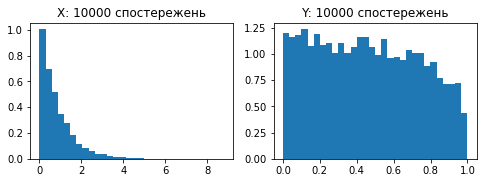

n= 10000
----Критерій Колмогорова----
Z_gamma = 1.36
Ho REJECTED
validation: True

Checking Y
Y NOT uniform

----Критерій хі-квадрат----
Z_gamma= 340.3278503488595
delta= 459.1802566865137
Ho REJECTED

Checking Y
Y NOT uniform

----Критерій пустих ящиків----
k= 733
bound= 709.653242816322
Ho REJECTED

Checking Y
Y NOT uniform
-----------------------------------------


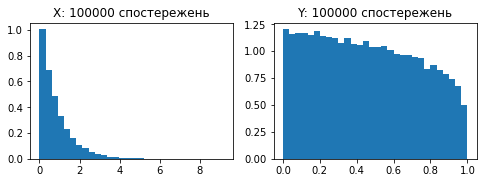

n= 100000
----Критерій Колмогорова----
Z_gamma = 1.36
Ho REJECTED
validation: True

Checking Y
Y NOT uniform

----Критерій хі-квадрат----
Z_gamma= 3127.515431571307
delta= 4432.481564692865
Ho REJECTED

Checking Y
Y NOT uniform

----Критерій пустих ящиків----
k= 7314
bound= 6871.0460439962335
Ho REJECTED

Checking Y
Y NOT uniform
-----------------------------------------


In [9]:
lambd_real = 1.2 #яка насправді
lambd_teor = 1 #яку ми перевіряємо

for n_i in n:
    X = gen_expon_values(n_i, lambd_real)
    Y = F_expon(X, lambd_teor)
    make_hist(X, 'X', n_i, Y, 'Y', n_i)
    print("n=", n_i)
    print("----Критерій Колмогорова----")
    kolmogorov_test(X, n_i, lambd_teor, gamma)
    check_Y_box(Y, n_i, gamma)
    
    print("\n----Критерій хі-квадрат----")
    chi2_pearson_test(X, n_i, gamma, lambd_teor)
    check_Y_box(Y, n_i, gamma)
    
    print("\n----Критерій пустих ящиків----")
    empty_box_test(X, n_i, lambd_teor, gamma)
    check_Y_box(Y, n_i, gamma)
    
    print("-----------------------------------------")

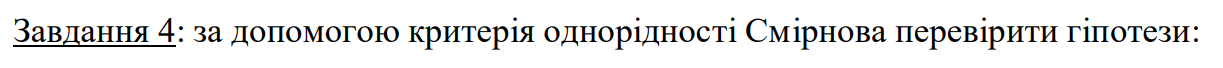

In [10]:
def checker_2samp(X, Y, gamma):
    x = ks_2samp(X, Y)
#     print(x)
    if x.pvalue < gamma:
        return 'rejected'
    else:
        return 'accepted'

In [11]:
def cdf_n_Y(X_ord, n, Y_ord, m): # Емпірична ф-я розподілу(Cumulative Distribution Function)
    cdf = [(np.sum(X_ord<=Y_ord[i])/n) for i in range(m)]
    return cdf

def D_2samp(X, Y, n, m, lambd):
    X_ord = np.sort(X) #order statistics
    Y_ord = np.sort(Y) #order statistics
    cdf = cdf_n_Y(X_ord, n, Y_ord, m)
    Dplus = np.max([(k/m - cdf[k]) for k in range(m)])
    Dminus = np.max([(cdf[k] - (k-1)/m)for k in range(m)])
    D = max(Dplus, Dminus)
    return D    


def kolmogorov_test_2samp(X, Y, n, m, lambd_teor, gamma):
    res = None
    Z_gamma = 1.36
    print("Z_gamma =", Z_gamma)
    D = D_2samp(X, Y, n, m, lambd_teor)
#     print("D=", D)
    print("srqt*D=", math.sqrt(n*m/(n+m)) * D)
    if math.sqrt(n*m/(n+m)) * D < Z_gamma:
        print("Ho ACCEPTED")
        res = 'accepted'
    else:
        print("Ho REJECTED")
        res = 'rejected'
    c = checker_2samp(X, Y, gamma)
    print(f"validation: {c == res}")

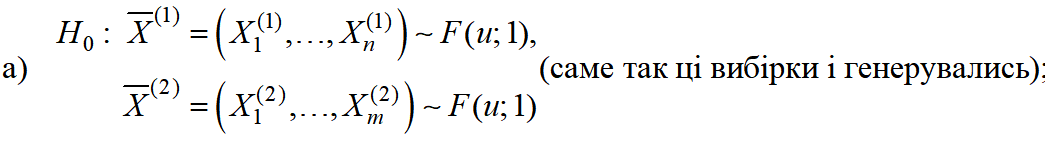

n= 1000 m= 500


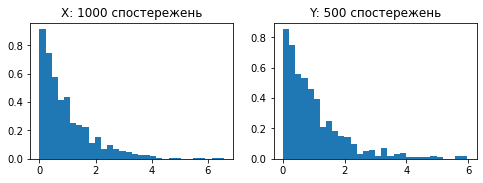

Z_gamma = 1.36
srqt*D= 0.6572670690061989
Ho ACCEPTED
validation: True
-----------------------------------------
n= 10000 m= 5000


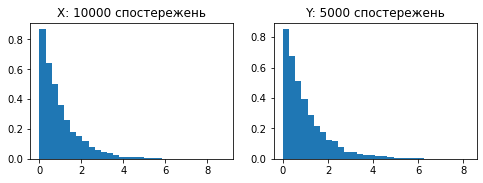

Z_gamma = 1.36
srqt*D= 0.5658032638058335
Ho ACCEPTED
validation: True
-----------------------------------------
n= 100000 m= 50000


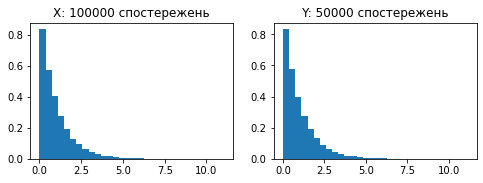

Z_gamma = 1.36
srqt*D= 0.6810017131647585
Ho ACCEPTED
validation: True
-----------------------------------------


In [33]:
lambd_real_X = 1 #яка насправді
lambd_real_Y = 1
lambd_teor = 1 #яку ми перевіряємо

for n_i in n:
    m_i = int(n_i/2)
    print("n=", n_i, "m=", m_i)
    X = gen_expon_values(n_i, lambd_real_X)
    Y = gen_expon_values(m_i, lambd_real_Y)
    make_hist(X, 'X', n_i, Y, 'Y', m_i)
    kolmogorov_test_2samp(X, Y, n_i, m_i, lambd_teor, gamma)
    print("-----------------------------------------")

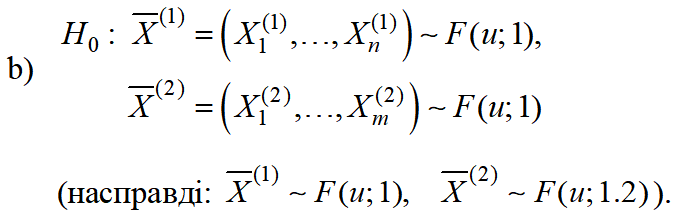

n= 1000 m= 500


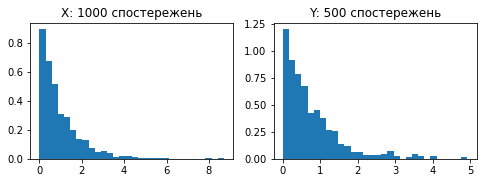

Z_gamma = 1.36
srqt*D= 1.8987715326845755
Ho REJECTED
validation: True
-----------------------------------------
n= 10000 m= 5000


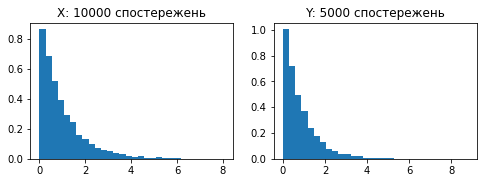

Z_gamma = 1.36
srqt*D= 3.949075841257041
Ho REJECTED
validation: True
-----------------------------------------
n= 100000 m= 50000


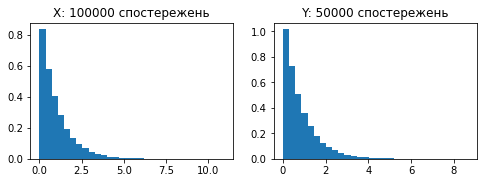

Z_gamma = 1.36
srqt*D= 12.948161259422145
Ho REJECTED
validation: True
-----------------------------------------


In [34]:
lambd_real_X = 1 #яка насправді
lambd_real_Y = 1.2
lambd_teor = 1 #яку ми перевіряємо

for n_i in n:
    m_i = int(n_i/2)
    print("n=", n_i, "m=", m_i)
    X = gen_expon_values(n_i, lambd_real_X)
    Y = gen_expon_values(m_i, lambd_real_Y)
    make_hist(X, 'X', n_i, Y, 'Y', m_i)
    kolmogorov_test_2samp(X, Y, n_i, m_i, lambd_teor, gamma)
    print("-----------------------------------------")